In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)

import warnings
warnings.filterwarnings('ignore')


In [2]:
fake_path = "/content/Fake_2000_rows.csv"
true_path = "/content/True_2000_rows.csv"

def load_split_data(fake_path, true_path):
    fake_df = pd.read_csv(fake_path)
    fake_df['label'] = 1  # Fake

    true_df = pd.read_csv(true_path)
    true_df['label'] = 0  # Real

    df = pd.concat([fake_df, true_df], ignore_index=True)

    if 'text' not in df.columns and 'content' in df.columns:
        df.rename(columns={'content': 'text'}, inplace=True)

    if 'text' not in df.columns:
        if 'title' in df.columns:
            df['text'] = df['title']
        else:
            raise ValueError("Missing 'text' or 'title' column.")

    df.dropna(subset=['text'], inplace=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

df = load_split_data(fake_path, true_path)


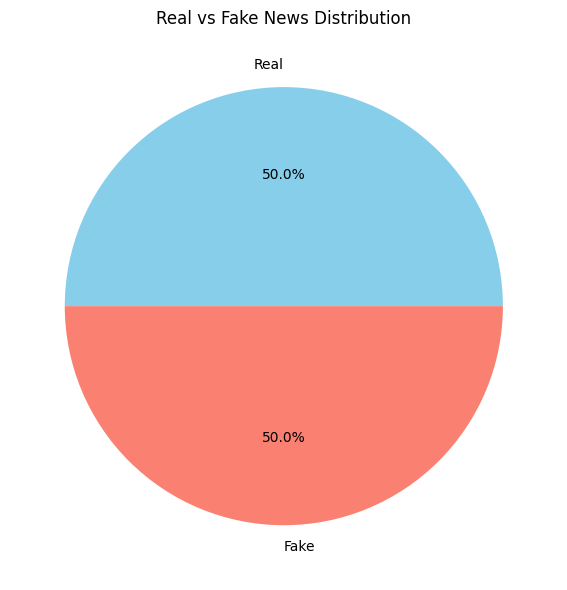

In [33]:
def plot_label_distribution(df):
    plt.figure(figsize=(6, 6))
    df['label'].value_counts().plot.pie(labels=['Real', 'Fake'], autopct='%1.1f%%', colors=['skyblue', 'salmon'])
    plt.title('Real vs Fake News Distribution')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

plot_label_distribution(df)

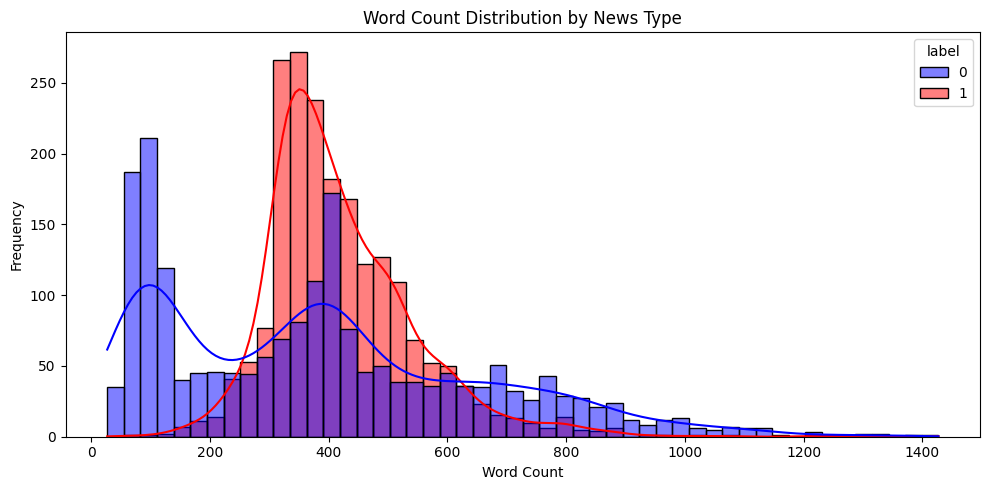

In [34]:
def plot_word_count_distribution(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x='word_count', hue='label', bins=50, kde=True, palette={0: 'blue', 1: 'red'})
    plt.title('Word Count Distribution by News Type')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_word_count_distribution(df)

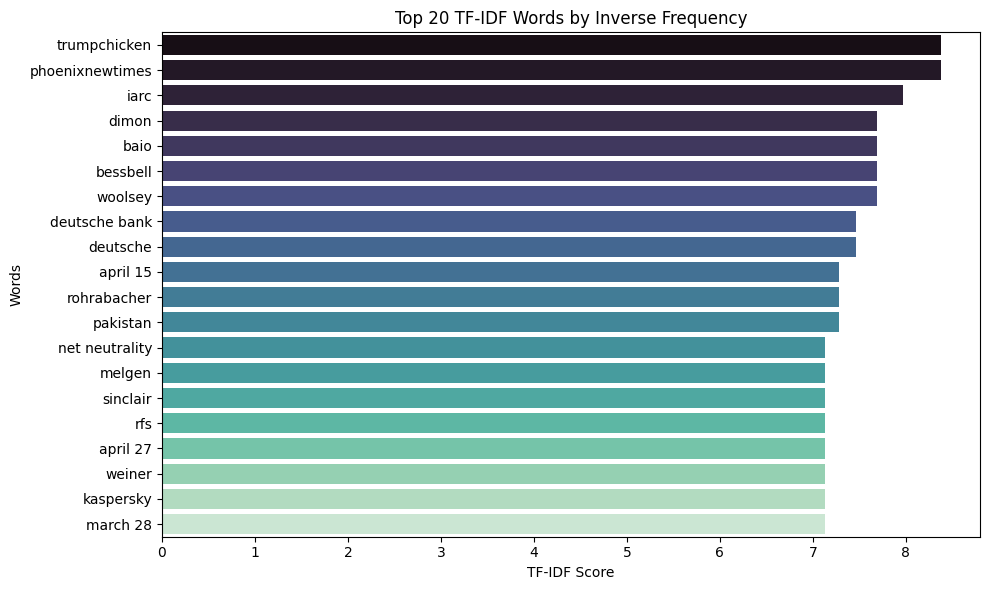

In [35]:
def plot_top_tfidf_words(vectorizer):
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(vectorizer.idf_)[::-1]
    top_n = feature_array[tfidf_sorting][:20]
    top_scores = vectorizer.idf_[tfidf_sorting][:20]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_scores, y=top_n, palette='mako')
    plt.title("Top 20 TF-IDF Words by Inverse Frequency")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

plot_top_tfidf_words(vectorizer)

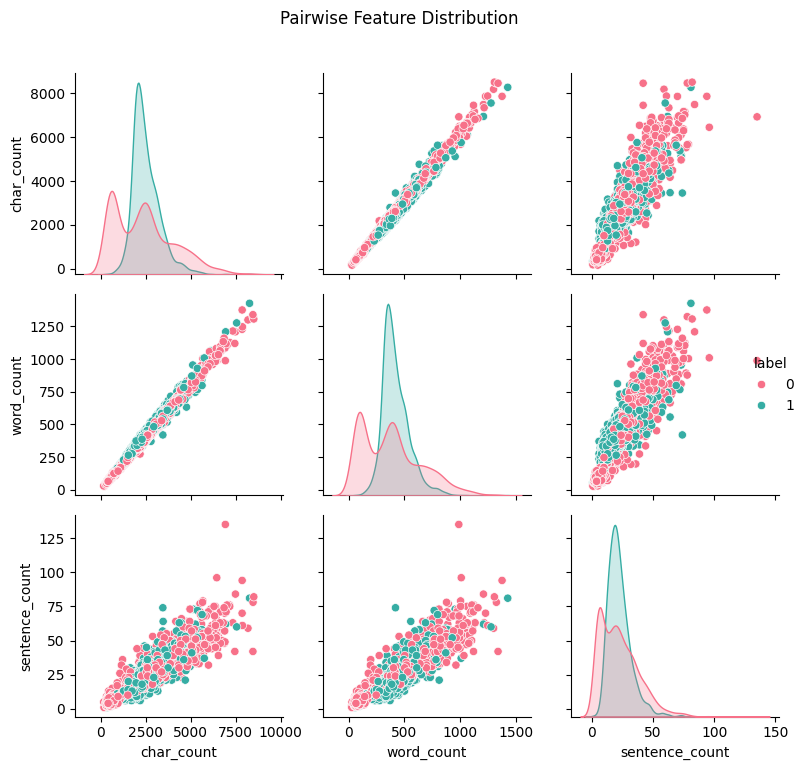

In [36]:
def generate_simple_features(df):
    df['char_count'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['sentence_count'] = df['text'].apply(lambda x: str(x).count('.'))

generate_simple_features(df)

def plot_pairwise_features(df):
    sns.pairplot(df[['char_count', 'word_count', 'sentence_count', 'label']], hue='label', palette='husl')
    plt.suptitle("Pairwise Feature Distribution", y=1.02)
    plt.tight_layout()
    plt.show()

plot_pairwise_features(df)


Dataset Overview:
Total: 4000
Real: 2000
Fake: 2000


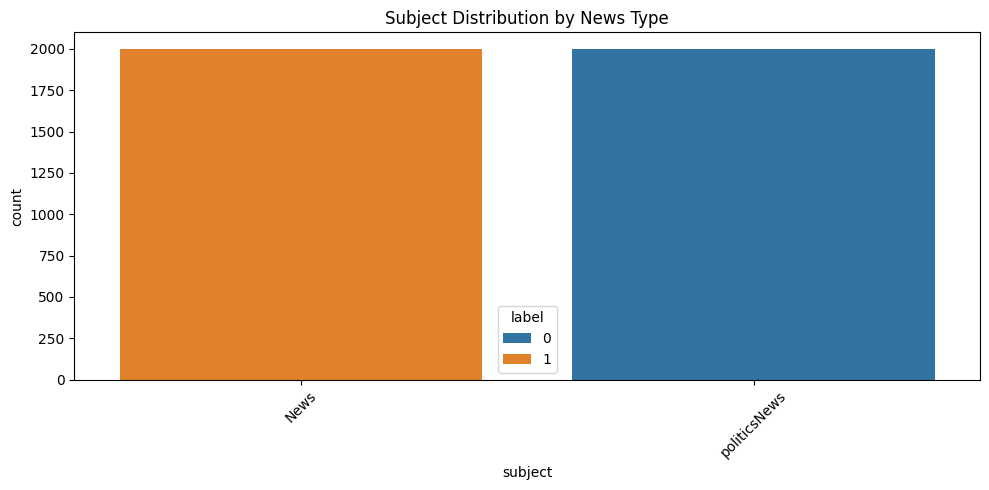

In [3]:
def analyze_dataset(df):
    print("\nDataset Overview:")
    print(f"Total: {len(df)}")
    print(f"Real: {sum(df['label'] == 0)}")
    print(f"Fake: {sum(df['label'] == 1)}")

    if 'subject' in df.columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x='subject', hue='label')
        plt.title("Subject Distribution by News Type")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

analyze_dataset(df)


In [4]:
def vectorize_text(df):
    X = df.apply(lambda row: f"{row['title']} {row['text']}" if 'title' in df.columns else row['text'], axis=1)
    y = df['label']

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
    X_train = tfidf.fit_transform(X_train_raw)
    X_test = tfidf.transform(X_test_raw)

    return X_train, X_test, y_train, y_test, tfidf

X_train, X_test, y_train, y_test, vectorizer = vectorize_text(df)


In [5]:
def plot_conf_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_test, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, n_jobs=-1,
                                                           train_sizes=np.linspace(0.1, 1.0, 5))
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Train')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation')
    plt.title(f"{model_name} - Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


In [6]:
def print_top_features(model, vectorizer, n=10):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-n:][::-1]
        feature_names = vectorizer.get_feature_names_out()
        print(f"\nTop {n} Features:")
        for i in indices:
            print(f"{feature_names[i]}: {importances[i]:.4f}")



=== Random Forest ===
              precision    recall  f1-score   support

   Real-News       1.00      1.00      1.00       402
   Fake-News       1.00      1.00      1.00       398

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



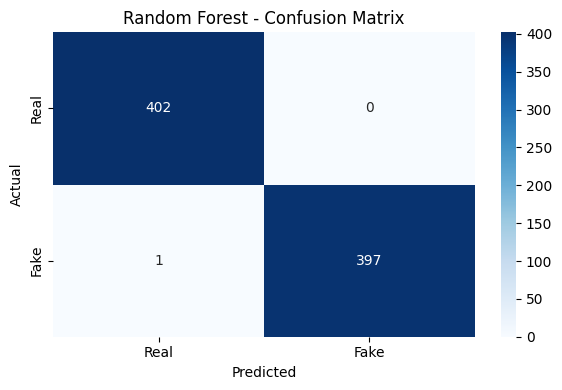

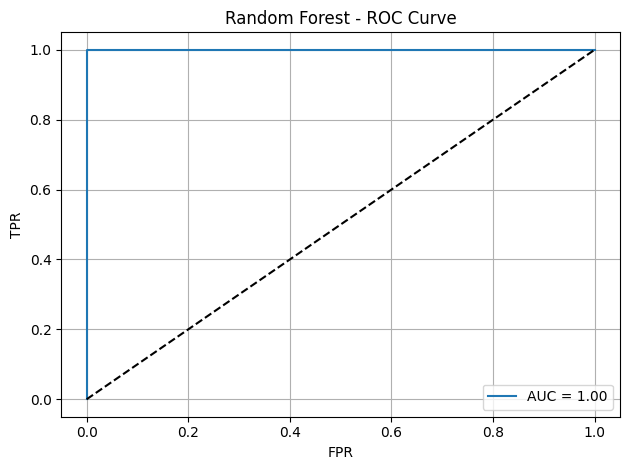

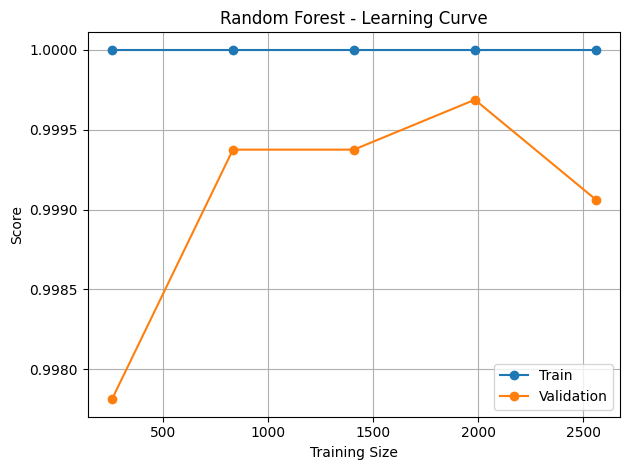


Top 10 Features:
images: 0.0757
reuters: 0.0717
image: 0.0595
getty images: 0.0523
featured image: 0.0515
featured: 0.0483
getty: 0.0412
washington reuters: 0.0242
said: 0.0190
president donald: 0.0174

=== KNN ===
              precision    recall  f1-score   support

   Real-News       0.85      0.92      0.88       402
   Fake-News       0.91      0.84      0.87       398

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



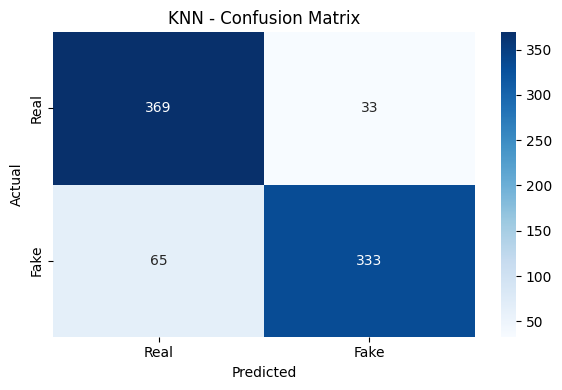

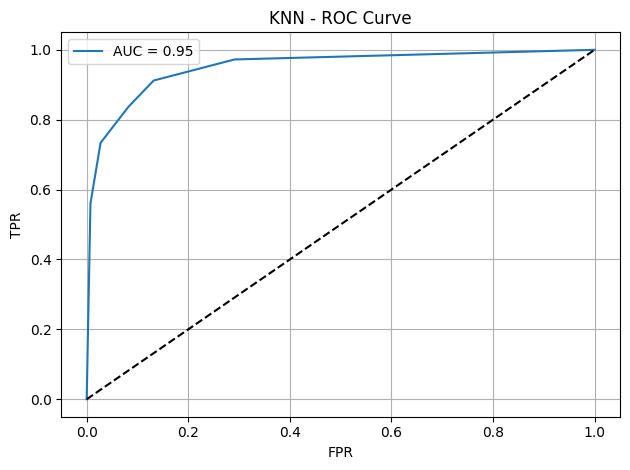

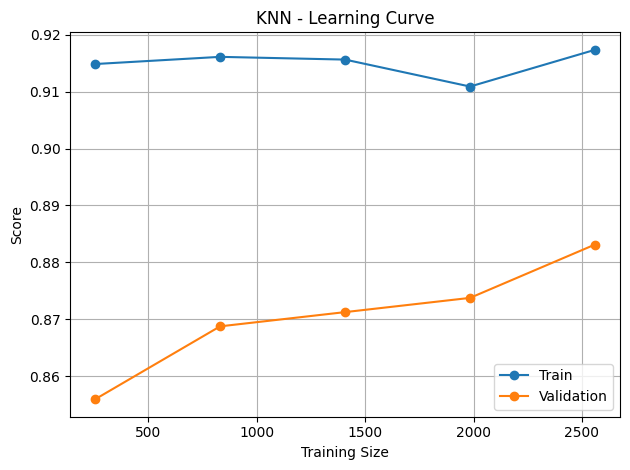


=== SVM ===
              precision    recall  f1-score   support

   Real-News       0.99      1.00      1.00       402
   Fake-News       1.00      0.99      0.99       398

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800



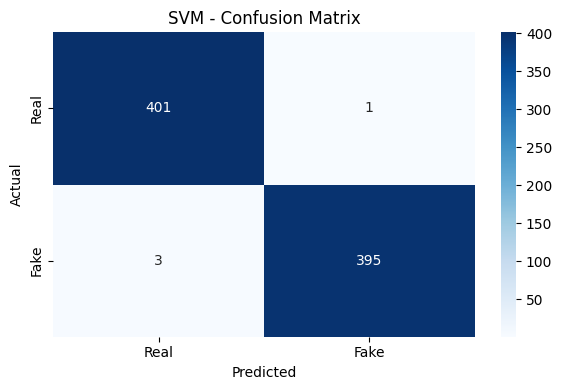

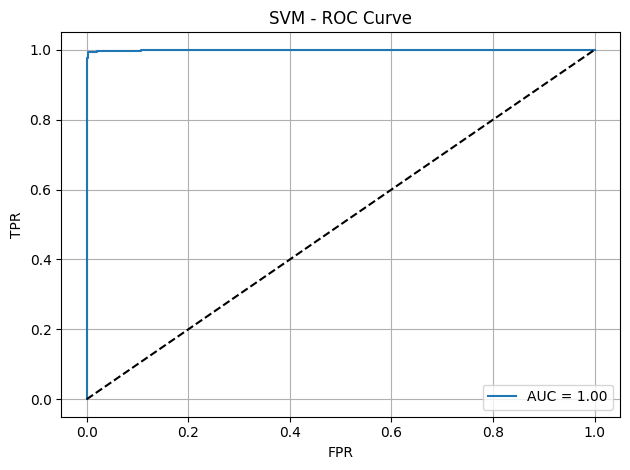

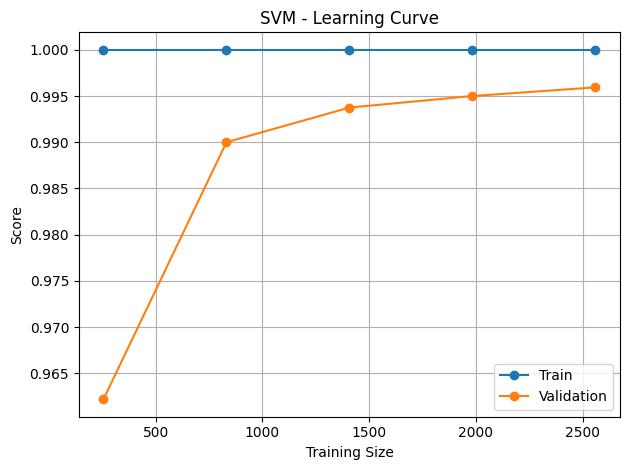


=== Gradient Boosting ===
              precision    recall  f1-score   support

   Real-News       0.99      1.00      0.99       402
   Fake-News       0.99      0.99      0.99       398

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



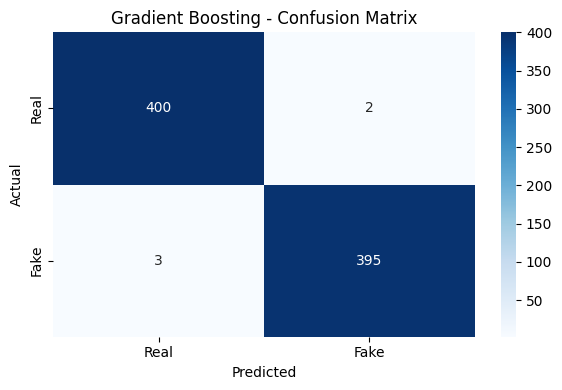

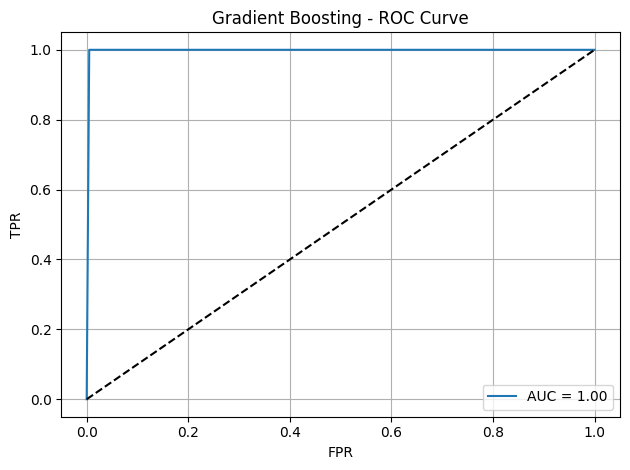

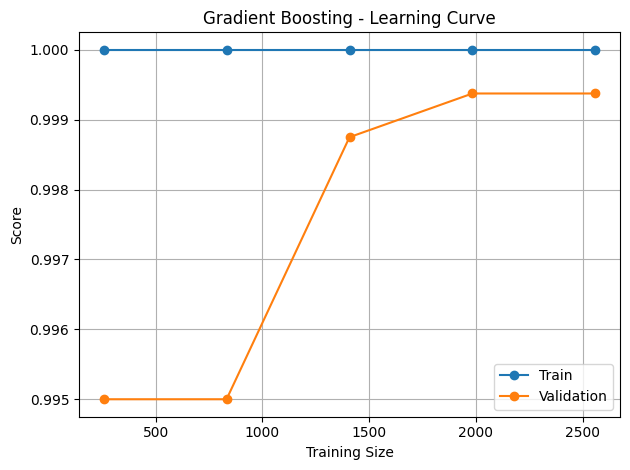


Top 10 Features:
reuters: 0.9802
getty: 0.0094
getty images: 0.0080
impeached: 0.0005
guidelines: 0.0003
review: 0.0003
ck: 0.0002
said letter: 0.0002
sectors: 0.0002
gets: 0.0002

=== Decision Tree ===
              precision    recall  f1-score   support

   Real-News       1.00      0.99      1.00       402
   Fake-News       0.99      1.00      1.00       398

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



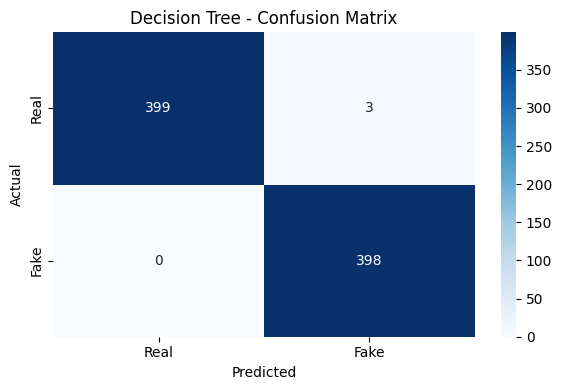

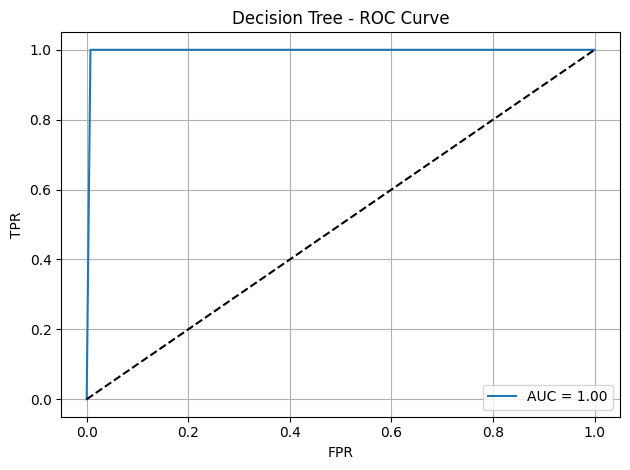

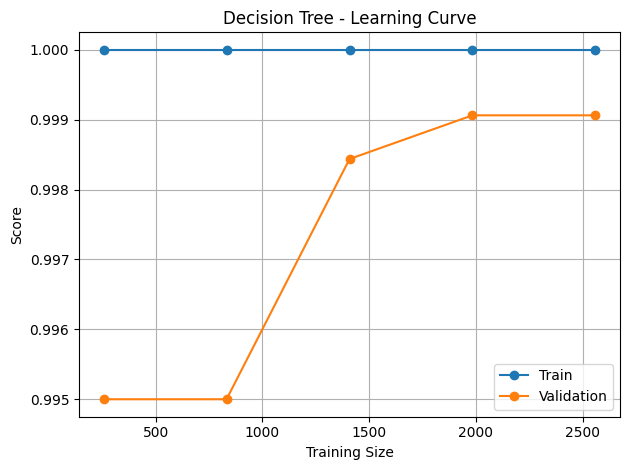


Top 10 Features:
reuters: 0.9802
getty: 0.0173
featured: 0.0012
review: 0.0012
famous: 0.0000
fan: 0.0000
fans: 0.0000
far: 0.0000
far right: 0.0000
farenthold: 0.0000

Final Results Summary:
                   Accuracy  Precision    Recall  F1-Score
Random Forest       0.99875   1.000000  0.997487  0.998742
KNN                 0.87750   0.909836  0.836683  0.871728
SVM                 0.99500   0.997475  0.992462  0.994962
Gradient Boosting   0.99375   0.994962  0.992462  0.993711
Decision Tree       0.99625   0.992519  1.000000  0.996245


In [7]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, vectorizer):
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(probability=True, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }

    results = {}

    for name, model in models.items():
        print(f"\n=== {name} ===")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, target_names=['Real-News', 'Fake-News'])
        print(classification_report(y_test, y_pred, target_names=['Real-News', 'Fake-News']))

        plot_conf_matrix(y_test, y_pred, name)
        if y_proba is not None:
            plot_roc_curve(y_test, y_proba, name)

        plot_learning_curve(model, X_train, y_train, name)
        print_top_features(model, vectorizer)

        results[name] = {
            'Accuracy': acc,
            'Precision': report['Fake-News']['precision'],
            'Recall': report['Fake-News']['recall'],
            'F1-Score': report['Fake-News']['f1-score']
        }

    return pd.DataFrame(results).T

results_df = train_and_evaluate_models(X_train, X_test, y_train, y_test, vectorizer)
print("\nFinal Results Summary:")
print(results_df)


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_features_from_models(models, vectorizer, top_n=10):
    feature_names = np.array(vectorizer.get_feature_names_out())
    feature_scores = {}

    for name, model in models.items():
        try:
            # Use .feature_importances_ for tree-based models
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
            # Use .coef_ for linear models like SVM
            elif hasattr(model, "coef_"):
                importances = np.abs(model.coef_).flatten()
            else:
                continue  # Skip models that don't support feature importances

            top_indices = np.argsort(importances)[-top_n:]
            for idx in top_indices:
                feat = feature_names[idx]
                feature_scores.setdefault(feat, {})[name] = importances[idx]

        except Exception as e:
            print(f"Could not extract features from {name}: {e}")

    # Create a sorted list of all top features
    all_top_feats = sorted(feature_scores.keys())

    # Plotting
    fig, ax = plt.subplots(figsize=(12, len(all_top_feats) * 0.5))
    x = np.arange(len(all_top_feats))
    width = 0.15  # width of the bars
    colors = plt.cm.tab10.colors

    for i, (model_name) in enumerate(models.keys()):
        values = [feature_scores.get(feat, {}).get(model_name, 0) for feat in all_top_feats]
        ax.barh(x + i * width, values, height=width, label=model_name, color=colors[i % len(colors)])

    ax.set_yticks(x + width * (len(models) - 1) / 2)
    ax.set_yticklabels(all_top_feats)
    ax.invert_yaxis()
    ax.set_xlabel("Feature Importance / Coefficient Magnitude")
    ax.set_title("Top Features from Multiple Models")
    ax.legend()
    plt.tight_layout()
    plt.show()


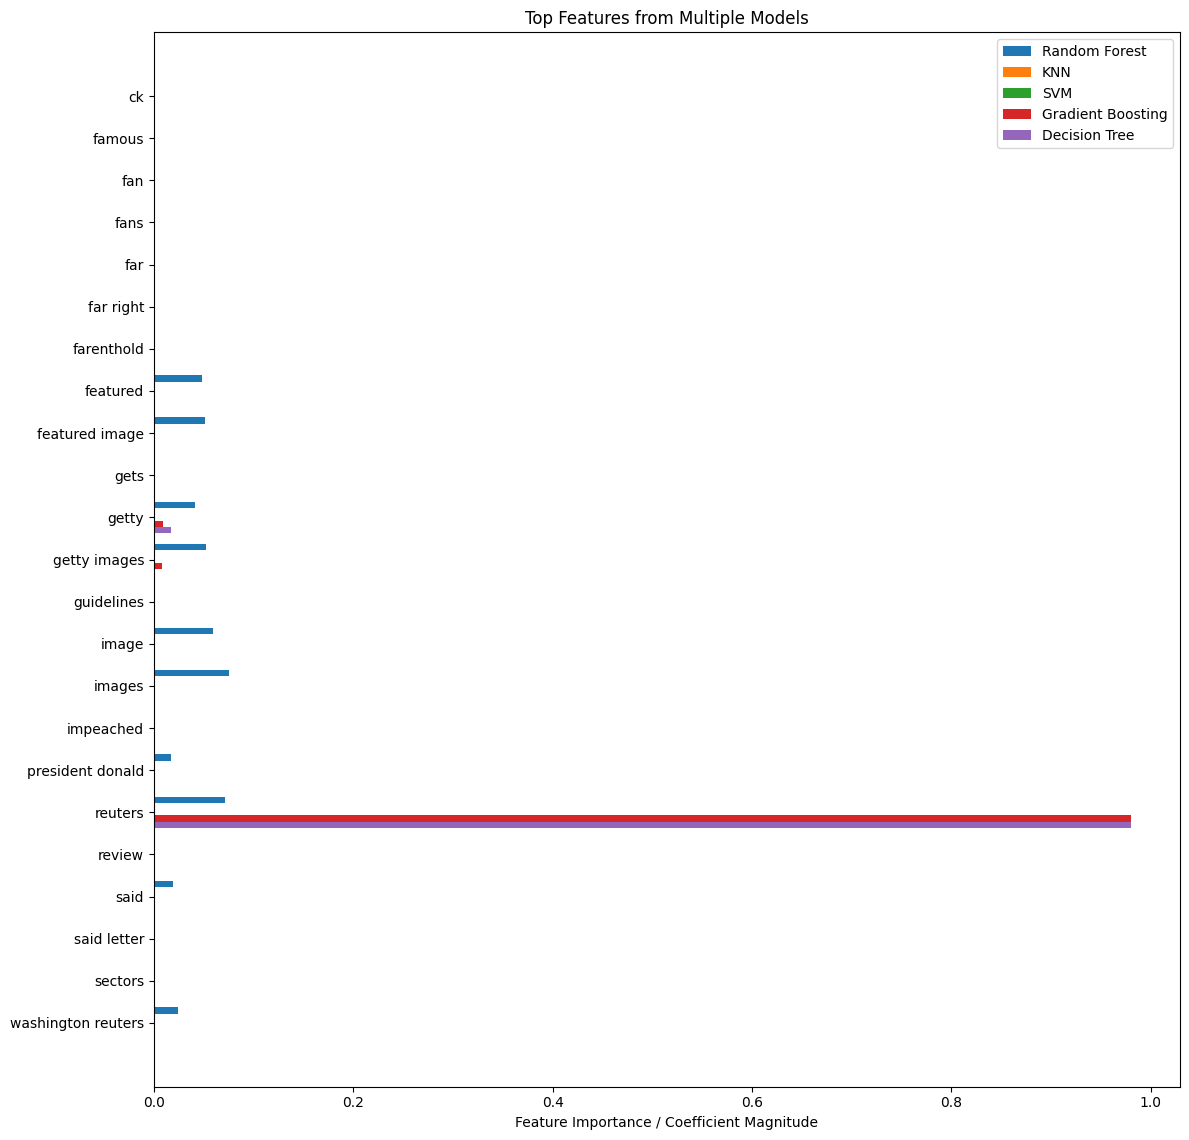

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ... (Rest of the function code remains the same) ...

# Store trained models in a dictionary
trained_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Fit the models before passing them to the plotting function
for name, model in trained_models.items():
    model.fit(X_train, y_train)

plot_top_features_from_models(trained_models, vectorizer) # Now call the function with the trained models

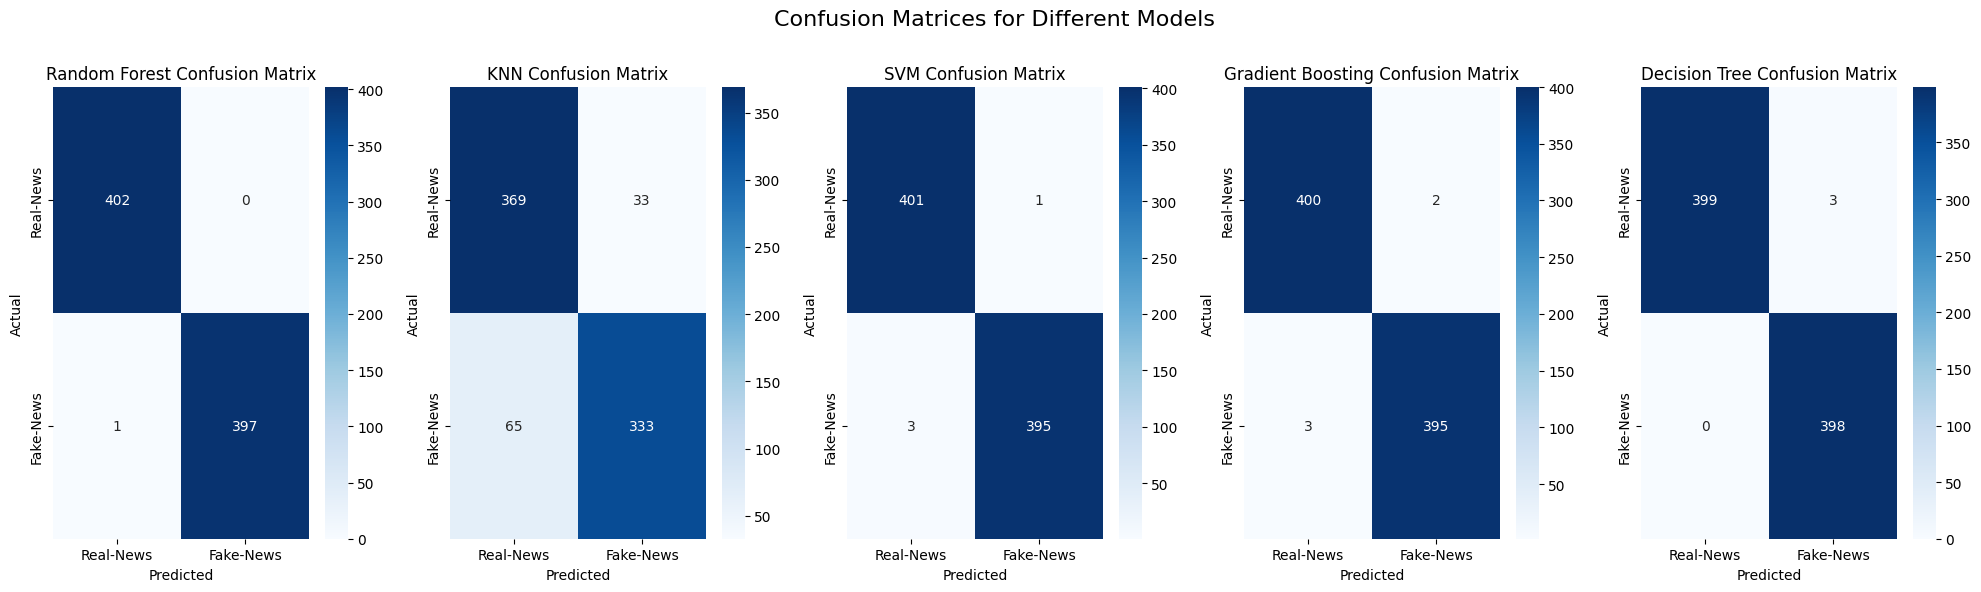

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_conf_matrix_for_models(models, X_test, y_test, model_names):
    """
    Plot confusion matrices for all models in one plot.
    """
    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
    fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

    for idx, (model, name) in enumerate(zip(models, model_names)):
        # Predict labels using each model
        y_pred = model.predict(X_test)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix using seaborn heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=['Real-News', 'Fake-News'],
                    yticklabels=['Real-News', 'Fake-News'])

        axes[idx].set_title(f'{name} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Example usage: assuming you have trained models and X_test, y_test
trained_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train all models
for name, model in trained_models.items():
    model.fit(X_train, y_train)

# Now, plot confusion matrices
plot_conf_matrix_for_models(list(trained_models.values()), X_test, y_test, list(trained_models.keys()))

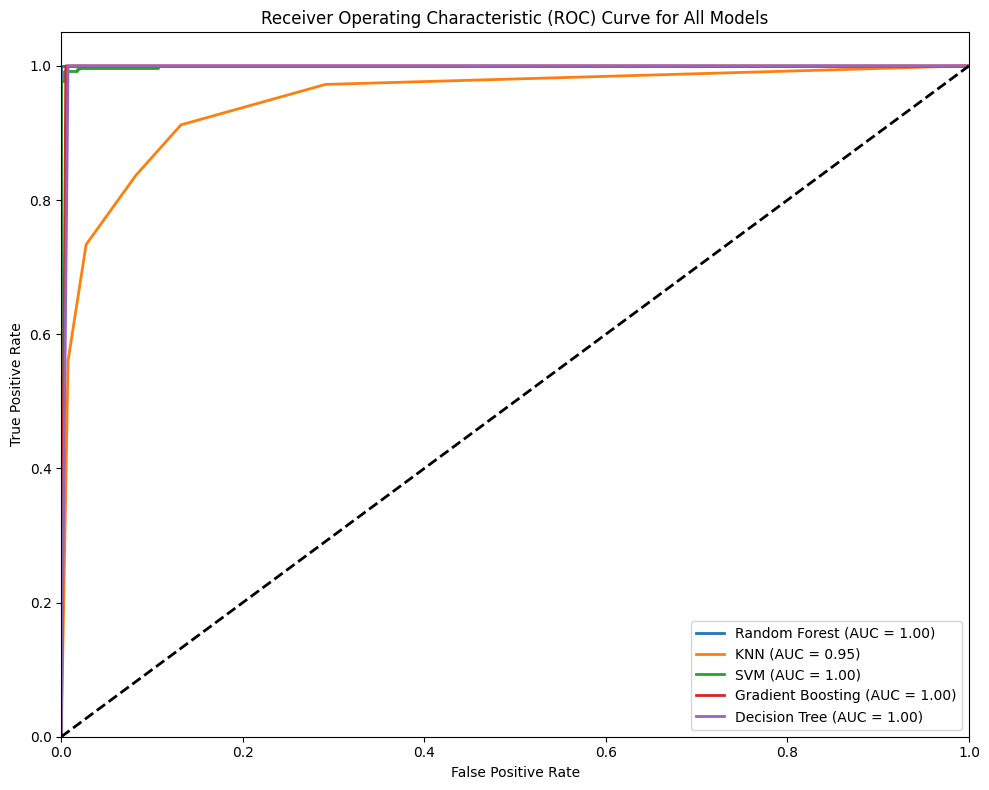

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def plot_roc_curve_for_models(models, X_test, y_test, model_names):
    """
    Plot ROC curve for all models in one plot.
    """
    plt.figure(figsize=(10, 8))

    # Binarize the labels for ROC curve
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    for model, name in zip(models, model_names):
        # Get the predicted probabilities
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Fake News)

        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal line (random model)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for All Models')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Example usage: assuming you have trained models and X_test, y_test
trained_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train all models
for name, model in trained_models.items():
    model.fit(X_train, y_train)

# Now, plot ROC curves
plot_roc_curve_for_models(list(trained_models.values()), X_test, y_test, list(trained_models.keys()))

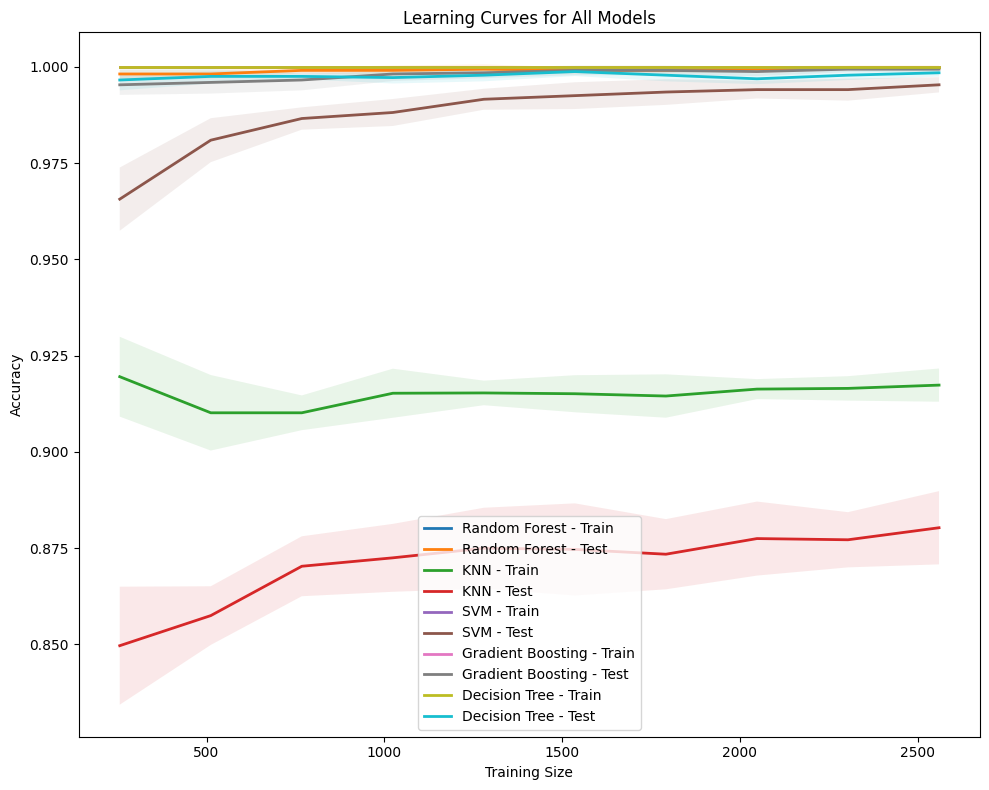

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle

def plot_learning_curve_for_models(models, X_train, y_train, model_names):
    """
    Plot learning curves for all models in one plot.
    """
    plt.figure(figsize=(10, 8))

    # Shuffle the data (important to avoid biasing the results)
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    for model, name in zip(models, model_names):
        # Get the learning curve data
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', shuffle=True
        )

        # Calculate mean and standard deviation for training and test scores
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        # Plot learning curve
        plt.plot(train_sizes, train_mean, label=f'{name} - Train', lw=2)
        plt.plot(train_sizes, test_mean, label=f'{name} - Test', lw=2)

        # Plot the shaded area for the standard deviation
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves for All Models')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Example usage: assuming you have trained models and X_train, y_train
trained_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train all models
for name, model in trained_models.items():
    model.fit(X_train, y_train)

# Now, plot learning curves
plot_learning_curve_for_models(list(trained_models.values()), X_train, y_train, list(trained_models.keys()))

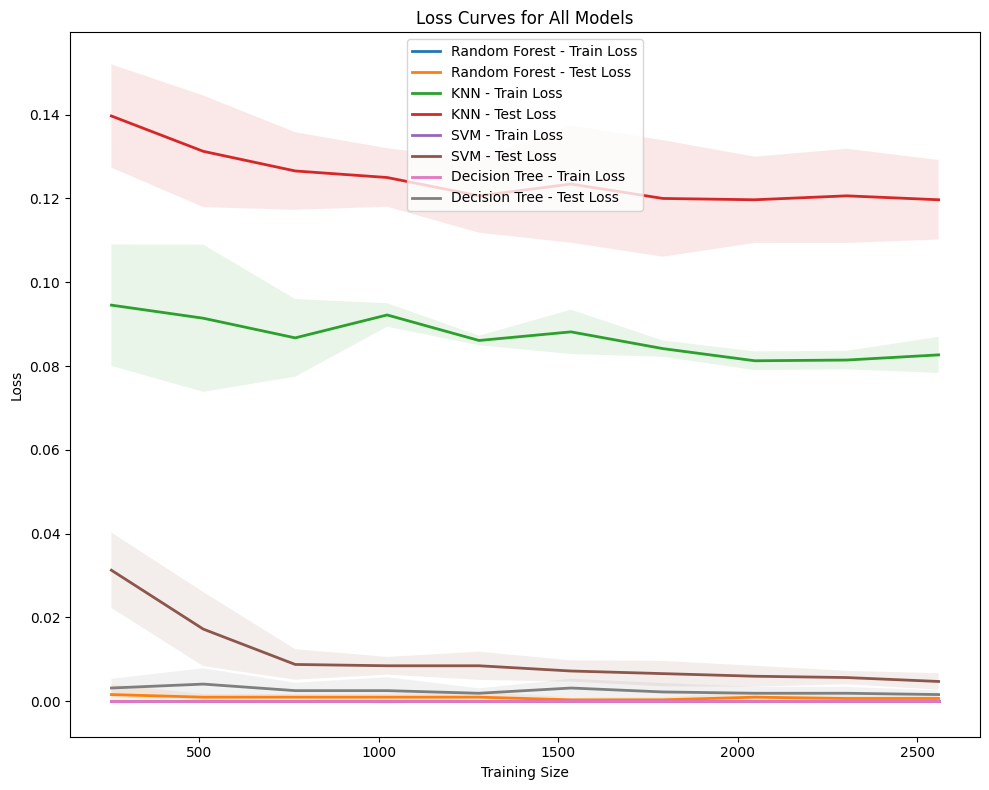

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

def plot_loss_curve_for_models(models, X_train, y_train, model_names):
    """
    Plot loss curves for all models in one plot.
    """
    plt.figure(figsize=(10, 8))

    # Shuffle the data (important to avoid biasing the results)
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    for model, name in zip(models, model_names):
        # Initialize an empty list to store losses at each stage
        train_losses = []
        test_losses = []

        # For models like Gradient Boosting, use staged_predict to track loss
        if hasattr(model, 'staged_predict'):
            for y_train_pred, y_test_pred in zip(model.staged_predict(X_train), model.staged_predict(X_test)):
                train_losses.append(log_loss(y_train, y_train_pred))
                test_losses.append(log_loss(y_test, y_test_pred))
        else:
            # For models without staged_predict (like Random Forest), use learning_curve to estimate loss
            train_sizes, train_scores, test_scores = learning_curve(
                model, X_train, y_train, cv=5, n_jobs=-1,
                train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', shuffle=True
            )

            # Calculate mean loss (error) for training and test sets
            train_mean = 1 - np.mean(train_scores, axis=1)  # Converting accuracy to error
            test_mean = 1 - np.mean(test_scores, axis=1)  # Converting accuracy to error

            # Plot loss curves
            plt.plot(train_sizes, train_mean, label=f'{name} - Train Loss', lw=2)
            plt.plot(train_sizes, test_mean, label=f'{name} - Test Loss', lw=2)

            # Plot the shaded area for the standard deviation
            train_std = np.std(train_scores, axis=1)
            test_std = np.std(test_scores, axis=1)
            plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
            plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.xlabel('Training Size')
    plt.ylabel('Loss')
    plt.title('Loss Curves for All Models')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Example usage: assuming you have trained models and X_train, y_train
trained_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train all models
for name, model in trained_models.items():
    model.fit(X_train, y_train)

# Now, plot loss curves
plot_loss_curve_for_models(list(trained_models.values()), X_train, y_train, list(trained_models.keys()))

Random Forest Accuracy: 0.9988
KNN Accuracy: 0.8775
SVM Accuracy: 0.9950
Gradient Boosting Accuracy: 0.9938
Decision Tree Accuracy: 0.9962


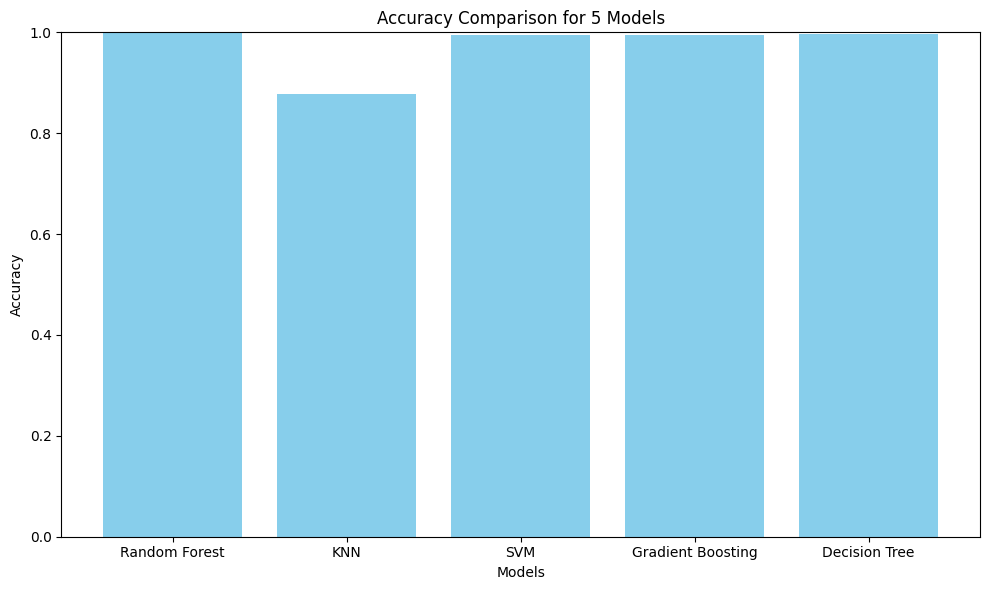

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def plot_accuracy_comparison(models, X_train, X_test, y_train, y_test, model_names):
    """
    Plot accuracy comparison for all models in one plot.
    """
    accuracies = []

    # Train each model and calculate accuracy
    for model, name in zip(models, model_names):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        print(f"{name} Accuracy: {accuracy:.4f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, accuracies, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison for 5 Models')
    plt.ylim(0, 1)  # Set the y-axis from 0 to 1
    plt.tight_layout()
    plt.show()

# Example usage:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    KNeighborsClassifier(),
    SVC(probability=True, random_state=42),
    GradientBoostingClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42)
]

model_names = ['Random Forest', 'KNN', 'SVM', 'Gradient Boosting', 'Decision Tree']

# Assuming X_train, X_test, y_train, y_test are already defined (split from your dataset)
plot_accuracy_comparison(models, X_train, X_test, y_train, y_test, model_names)